# Homework 2, question 2:


As extensively discussed in class, the drift-diffusion model (DDM) generates two response time (RT)
distributions, one for each boundary (i.e., lower and upper boundaries). This exercise asks you to
first explore a somewhat counterintuitive question about the basic DDM: What differences between
the means of the two RT distributions does the the model predict?


To approach this question from a simulation-based perspective, you need to repeatedly solve
the forward problem with different parameter configurations and collect the two summary statistics, namely, the two empirical means of the resulting RT distributions. First, choose a suitable
configuration of the four parameters and vary only the drift rates within a reasonable range (e.g.,
v ∈ [0.5 − 1.5]) for a total of 25 different drift rates. Make sure that your parameterizations can
generate a sufficient number of RTs for both distributions and you don’t end up with the process
only reaching the upper boundary. Second, for each of your parameter configurations, generate
N = 2000 synthetic observations and estimate the means of the two distributions. What do you
observe regarding the mean difference? Describe and interpret your results. (4 points)


In a similar spirit (keeping all parameters fixed and varying one), explore the effects of each of
the parameters on the means and standard deviations of the simulated RT distributions, quantify
and describe your results. (4 points)


In [133]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

## Drift Diffusion Model

In [134]:
@njit
def simulate_diffusion(v, a, beta, tau, dt=1e-3, scale=1.0, max_time=10.):
    """
    Simulates one realization of the diffusion process given
    a set of parameters and a step size `dt`.

    Parameters:
    -----------
    v        : float
        The drift rate (rate of information uptake)
    a        : float
        The boundary separation (decision threshold).
    beta     : float in [0, 1]
        Relative starting point (prior option preferences)
    tau      : float
        Non-decision time (additive constant)
    dt       : float, optional (default: 1e-3 = 0.001)
        The step size for the Euler algorithm.
    scale    : float, optional (default: 1.0)
        The scale (sqrt(var)) of the Wiener process. Not considered
        a parameter and typically fixed to either 1.0 or 0.1.
    max_time : float, optional (default: .10)
        The maximum number of seconds before forced termination.
    rng      : np.random.Generator or None, optional (default: None)
        A random number generator with locally set seed or None
        If None provided, a new generator will be spawned within the function.
        
    Returns:
    --------
    (x, c) - a tuple of response time (y - float) and a 
        binary decision (c - int) 
    """

    # Inits (process starts at relative starting point)
    y = beta * a
    num_steps = tau
    const = scale*np.sqrt(dt)

    # Loop through process and check boundary conditions
    while (y <= a and y >= 0) and num_steps <= max_time:

        # Perform diffusion equation
        z = np.random.randn()
        y += v*dt + const*z

        # Increment step counter
        num_steps += dt

    if y >= a:
        c = 1.
    else:
        c = 0.
    return (round(num_steps, 4), c)

In [135]:
# Simulate multiple realizations of the diffusion process
@njit
def simulate_diffusion_n(num_sims, v, a, beta, tau, dt=1e-3, scale=1.0, max_time=10., rng=None):
    """
    Simulates n realizations of the diffusion process given
    a set of parameters and a step size `dt`.

    Parameters:
    -----------

    Returns:
    --------

    """

    # Inits
    data = np.zeros((num_sims, 2))
    
    # Create data set
    for n in range(num_sims):
        data[n, :] = simulate_diffusion(v, a, beta, tau, dt, scale, max_time)
    return data


In [136]:
# Visualize the mean of each distribution:
def visualize_data(c1_rt_data, c2_rt_data, figsize=(10, 5)):
    """Helper function to visualize a simple response time data set."""

    f, axarr = plt.subplots(1, 2, figsize=figsize)
    
    # Histogram of response times
    sns.histplot(
        c1_rt_data, ax=axarr[0], color='#AA0000', alpha=0.8, lw=2, label=f'Response 1')
    sns.histplot(
        c2_rt_data, ax=axarr[0], color='#0000AA', alpha=0.8, lw=2, label=f'Response 0')

    # Barplot of categorical responses
    response_names = ['Response 1', 'Response 0']
    response_means = [np.mean(c1_rt_data), np.mean(c2_rt_data)]
    sns.barplot(x=response_names, y=response_means, ax=axarr[1], alpha=0.8, color='#00AA00')

    # Labels and embelishments
    axarr[0].set_xlabel('Response time (s)', fontsize=16)
    axarr[0].legend(fontsize=16)
    axarr[0].set_ylabel('Count', fontsize=16)
    axarr[1].set_xlabel('Response Type', fontsize=16)
    axarr[1].set_ylabel('Mean', fontsize=16)
    for ax in axarr:
        sns.despine(ax=ax)
        ax.grid(alpha=0.1, color='black')

    f.suptitle('Data Summary', fontsize=18)

    f.tight_layout()

def visualize_rt_means(value_range, c1_rt_m, c2_rt_m, value_title, y_label='Mean Response Time', figsize=(10, 5)):
    """Helper function to visualize the mean response time as a function of drift rate."""

    f, ax = plt.subplots(1, 1, figsize=figsize)
    if(len(c1_rt_m) != 0):
        sns.lineplot(x=value_range, y=c1_rt_m, ax=ax, label='Response 1')
    if(len(c2_rt_m) != 0):
        sns.lineplot(x=value_range, y=c2_rt_m, ax=ax, label='Response 2')
    ax.set_xlabel(value_title, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    ax.legend(fontsize=16)
    sns.despine(ax=ax)
    ax.grid(alpha=0.1, color='black')
    f.suptitle(y_label + ' by ' + value_title, fontsize=18)
    return f, ax

In [137]:
# Simulate parameters

# Ensure reproducibility
RNG = np.random.default_rng(2024)

# Set ground-truth parameters
control_params = {
    'v': 1.6,
    'a': 2,
    'beta': 0.5,
    'tau': 0.4
}

# Set additional simulation settings
control = {
    'num_sims': 2000,
    'rng': RNG,
    'dt': 1e-3
}

### Simulate Data

In [138]:
# Varying v:
v_range = np.linspace(0.5, 1.5, 25)
c1_rt = []
c2_rt = []
c1_rt_m = []
c2_rt_m = []
parameters_v = control_params
# Create data with specification's variations
for drift_rate in v_range:
    parameters_v['v'] = drift_rate
    data = simulate_diffusion_n(**{**control, **parameters_v})

    c1_rt_temp = []
    c2_rt_temp = []

    for i in range(len(data)):
        if data[i][1] == 1:
            c1_rt_temp.append(data[i][0])
        else:
            c2_rt_temp.append(data[i][0])

    c1_rt.extend(c1_rt_temp)
    c2_rt.extend(c2_rt_temp)

    # identify the mean of each distribution
    c1_rt_m.append(np.mean(c1_rt_temp))
    c2_rt_m.append(np.mean(c2_rt_temp))

/home/matt/miniconda3/envs/cognitive/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/matt/miniconda3/envs/cognitive/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/matt/miniconda3/envs/cognitive/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/matt/miniconda3/envs/cognitive/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='Drift Rate', ylabel='Mean Response Time'>)

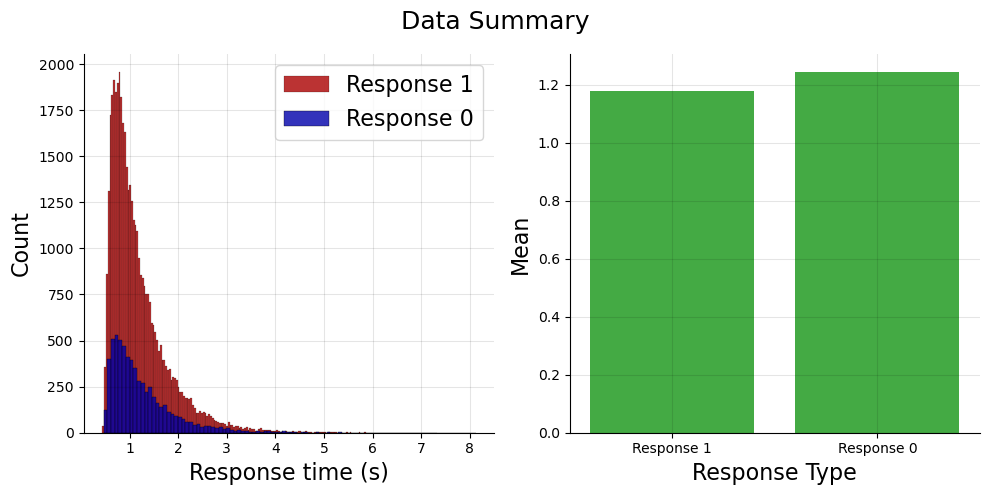

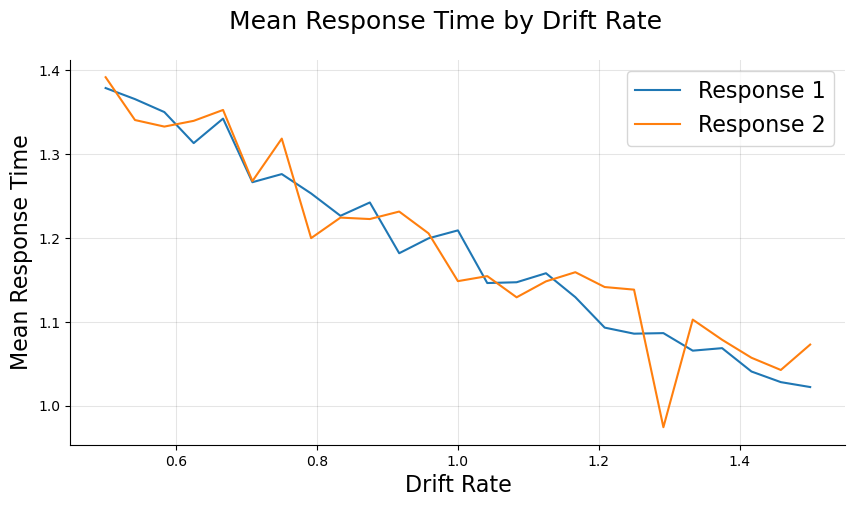

In [139]:
# Visualize the drift rate data
visualize_data(c1_rt, c2_rt)
visualize_rt_means(v_range, c1_rt_m, c2_rt_m, 'Drift Rate')

### Drift Rate Analysis:

Intuition tells us that the more information a person has, the more confident/faster they will be in making a decision. Our analysis of the mean response time for the varying drift rates supports this hypothesis. Since the drift rate represents the average rate of continuous information uptake (evidence) in favor of one alternative - the higher it becomes, the faster a person can make a decision. The inverse of this can also be stated in that the lower the drift rate, the longer the mean response time will be, best metaphorically represented by a situation where little information is had leading to taking more time to make a decision.

/home/matt/miniconda3/envs/cognitive/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/matt/miniconda3/envs/cognitive/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/matt/miniconda3/envs/cognitive/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/matt/miniconda3/envs/cognitive/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='Alpha', ylabel='STD Response Time'>)

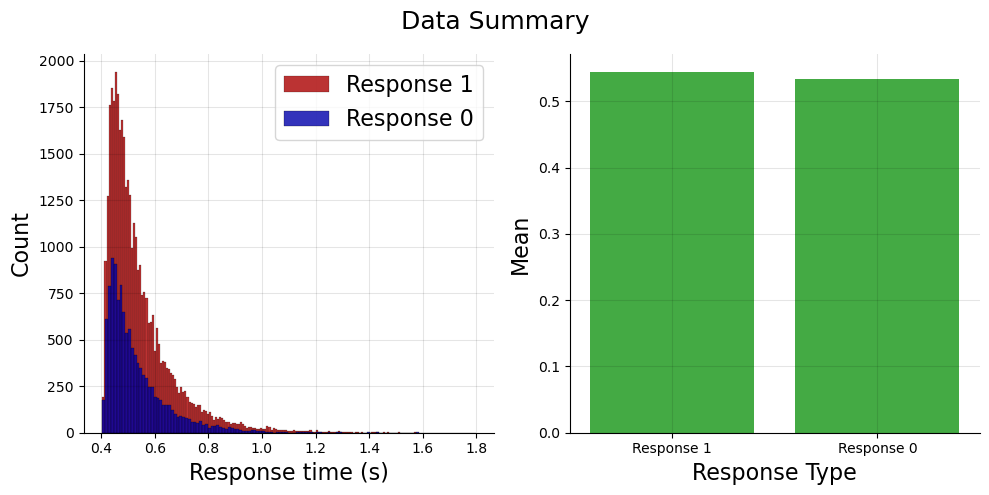

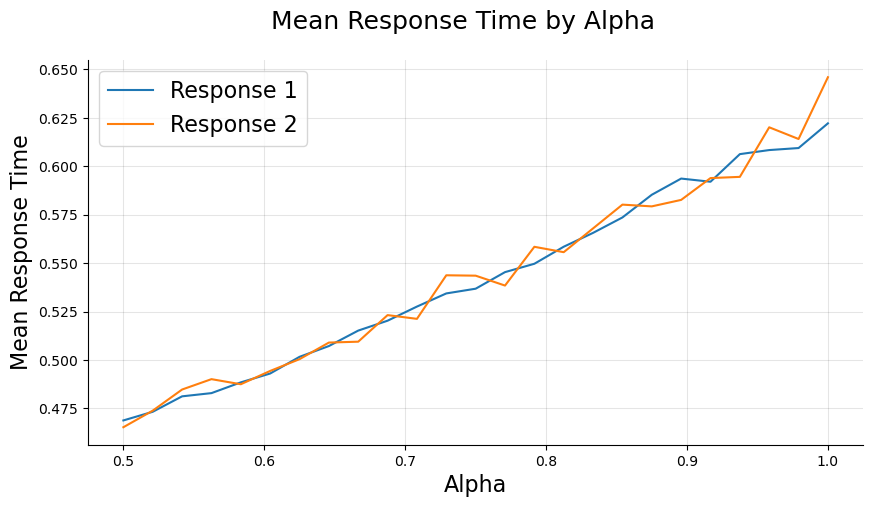

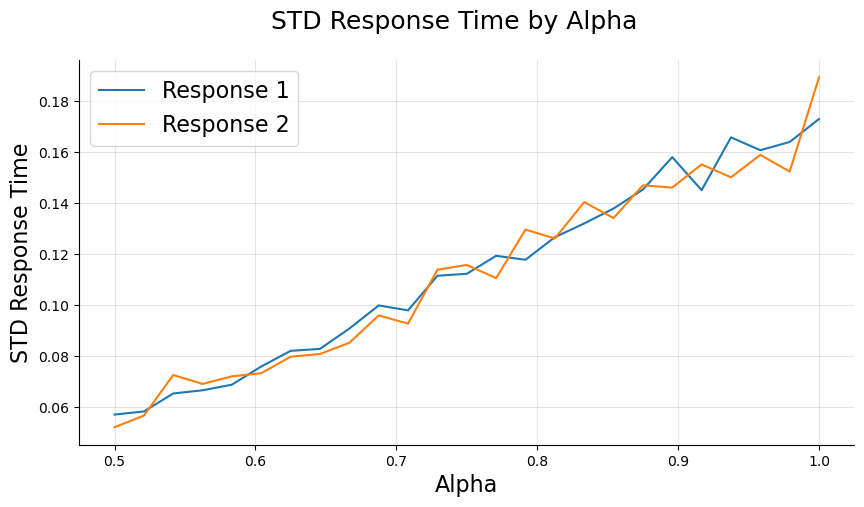

In [140]:
# Varying beta
alpha_range = np.linspace(0.5, 1.0, 25)
c1_rt = []
c2_rt = []
c1_rt_m = []
c2_rt_m = []
c1_rt_std = []
c2_rt_std = []
parameters_alpha = control_params
for alpha in alpha_range:
    parameters_alpha['a'] = alpha
    data = simulate_diffusion_n(**{**control, **parameters_alpha})

    c1_rt_temp = []
    c2_rt_temp = []

    for i in range(len(data)):
        if data[i][1] == 1:
            c1_rt_temp.append(data[i][0])
        else:
            c2_rt_temp.append(data[i][0])

    c1_rt.extend(c1_rt_temp)
    c2_rt.extend(c2_rt_temp)

    # identify the mean of each distribution
    c1_rt_m.append(np.mean(c1_rt_temp.copy()))
    c1_rt_std.append(np.std(c1_rt_temp.copy()))
    if(c2_rt_temp == []):
        c2_rt_m.append(0)
        c2_rt_std.append(0)
    else:
        c2_rt_m.append(np.mean(c2_rt_temp.copy()))
        c2_rt_std.append(np.std(c2_rt_temp.copy()))

visualize_data(c1_rt, c2_rt)
visualize_rt_means(alpha_range, c1_rt_m, c2_rt_m, 'Alpha')
visualize_rt_means(alpha_range,c1_rt_std, c2_rt_std, 'Alpha', y_label="STD Response Time")

/home/matt/miniconda3/envs/cognitive/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/matt/miniconda3/envs/cognitive/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/matt/miniconda3/envs/cognitive/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/matt/miniconda3/envs/cognitive/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='Beta', ylabel='STD Response Time'>)

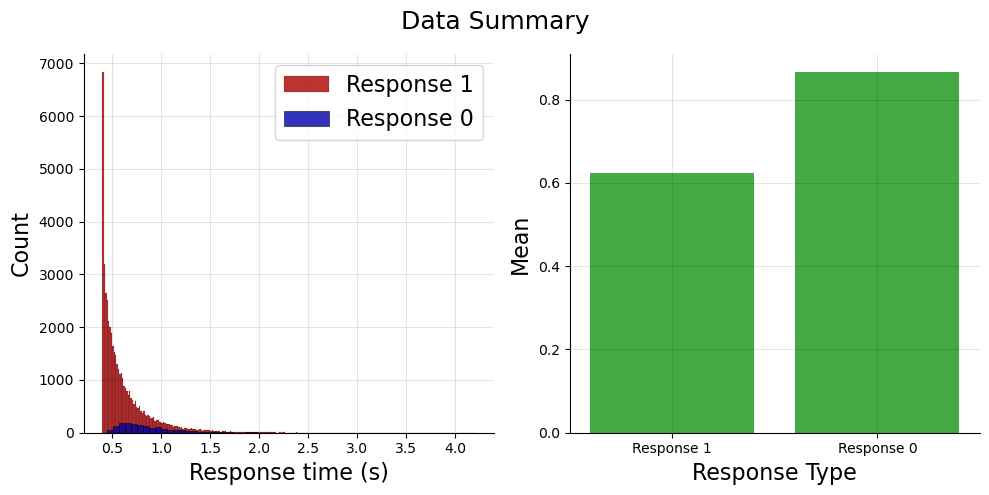

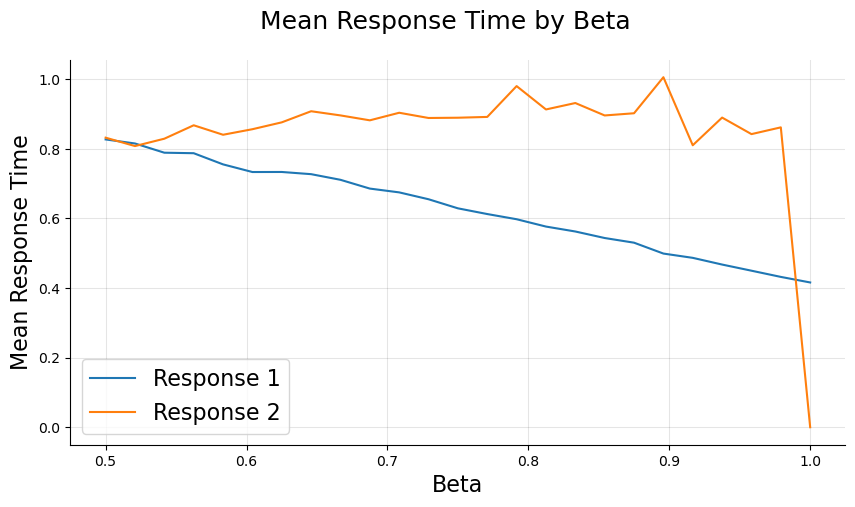

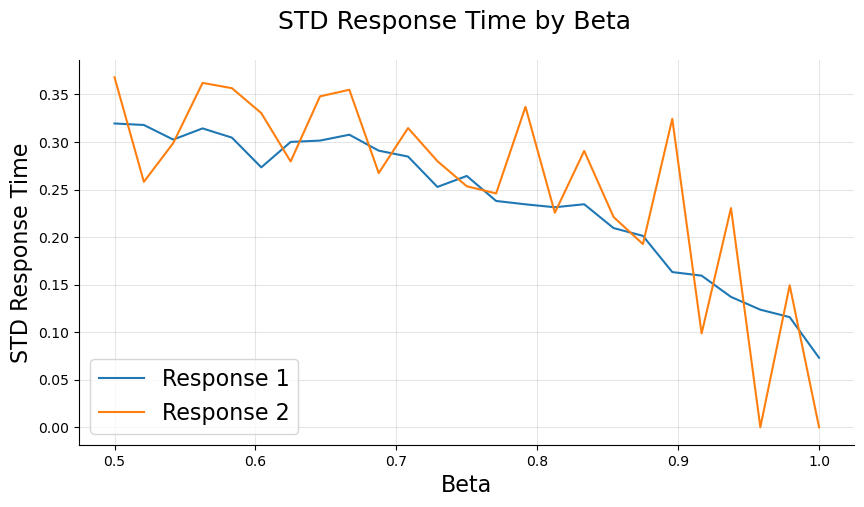

In [144]:
# Varying beta
beta_range = np.linspace(0.5, 1.0, 25)
c1_rt = []
c2_rt = []
c1_rt_m = []
c2_rt_m = []
c1_rt_std = []
c2_rt_std = []
parameters_beta = control_params
for beta in beta_range:
    parameters_beta['beta'] = beta
    data = simulate_diffusion_n(**{**control, **parameters_beta})

    c1_rt_temp = []
    c2_rt_temp = []

    for i in range(len(data)):
        if data[i][1] == 1:
            c1_rt_temp.append(data[i][0])
        else:
            c2_rt_temp.append(data[i][0])

    c1_rt.extend(c1_rt_temp)
    c2_rt.extend(c2_rt_temp)

    # identify the mean of each distribution
    c1_rt_m.append(np.mean(c1_rt_temp.copy()))
    c1_rt_std.append(np.std(c1_rt_temp.copy()))
    if(c2_rt_temp == []):
        c2_rt_m.append(0)
        c2_rt_std.append(0)
    else:
        c2_rt_m.append(np.mean(c2_rt_temp.copy()))
        c2_rt_std.append(np.std(c2_rt_temp.copy()))

visualize_data(c1_rt, c2_rt)
visualize_rt_means(beta_range, c1_rt_m, c2_rt_m, 'Beta')
visualize_rt_means(beta_range,c1_rt_std, c2_rt_std, 'Beta', y_label="STD Response Time")

In [145]:
# Varying Tau
tau_range = np.linspace(0.5, .1, 25)
c1_rt = []
c2_rt = []
c1_rt_m = []
c2_rt_m = []
c1_rt_std = []
c2_rt_std = []
parameters_tau = control_params
for tau in tau_range:
    parameters_tau['tau'] = tau
    data = simulate_diffusion_n(**{**control, **parameters_tau})
    
    c1_rt_temp = []
    c2_rt_temp = []
    

    for i in range(len(data)):
        if data[i][1] == 1:
            c1_rt_temp.append(data[i][0])
        else:
            if(data[i][0] == np.NaN):
                c2_rt_temp.append(0)
            else:
                c2_rt_temp.append(data[i][0])
                
    c1_rt.extend(c1_rt_temp.copy())
    c2_rt.extend(c2_rt_temp.copy())

    # identify the mean of each distribution
    c1_rt_m.append(np.mean(c1_rt_temp.copy()))
    c1_rt_std.append(np.std(c1_rt_temp.copy()))
    if(c2_rt_temp == []):
        c2_rt_m.append(0)
        c2_rt_std.append(0)
    else:
        c2_rt_m.append(np.mean(c2_rt_temp.copy()))
        c2_rt_std.append(np.std(c2_rt_temp.copy()))

/home/matt/miniconda3/envs/cognitive/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/matt/miniconda3/envs/cognitive/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/matt/miniconda3/envs/cognitive/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/matt/miniconda3/envs/cognitive/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='Tau', ylabel='STD Response Time'>)

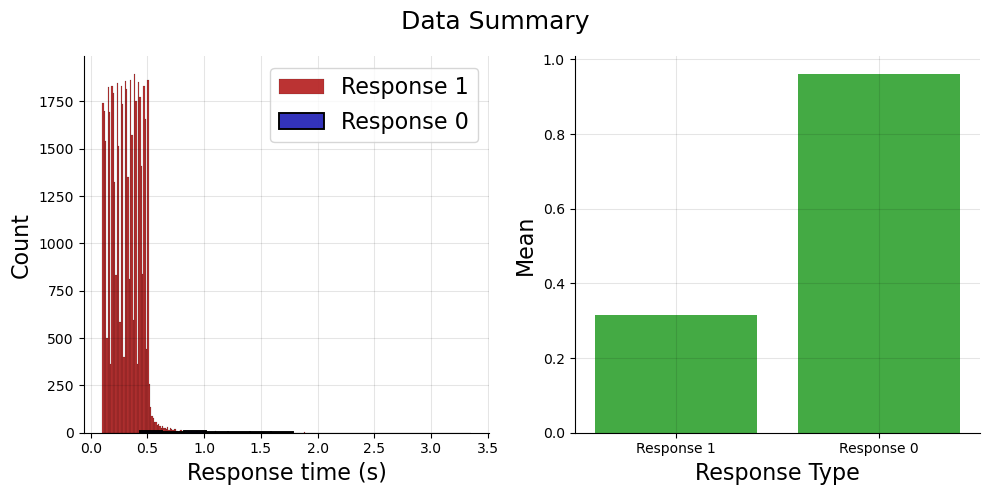

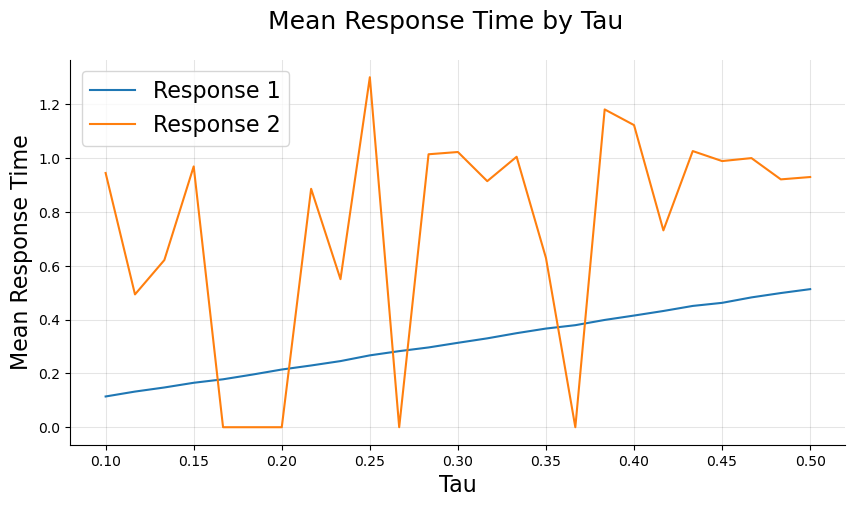

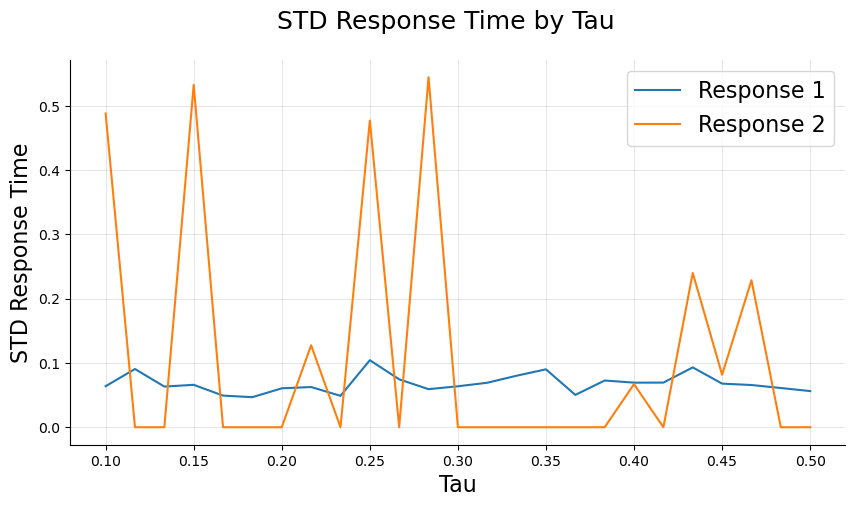

In [146]:
visualize_data(c1_rt, c2_rt)
visualize_rt_means(tau_range,c1_rt_m, c2_rt_m, 'Tau')
visualize_rt_means(tau_range,c1_rt_std, c2_rt_std, 'Tau', y_label="STD Response Time")

### Analysis of Varying other parameters:

**Boundary separation (a)**
As the boundary separation quanitifed by the variable a is increased, there is a proportional increase to the mean decision time for each option. This correlation between the boundary separation variable and the mean response time for each option supports an intuitive interpretation that when a person chooses an option if the threshold to make a decision is increased, the more time a person would need to consider what is in front of them in order to make a decision. 

**Starting point (β)**
Graphically, we can tell that the two responses are much less correlated than the boundary separation variable. We see that the mean response time for response 2 shows consistency, unlike response 1, as beta increases - this is most likely due to what beta represents. As we know, beta represents the (relative) starting point of the process, indicating a prior preference (bias) towards a particular alternative. If beta shrinks the distance between the starting point and a decision, a graph such as the one we have of randomly distributed trails should show a correlation with a response time decrease.


**Non-decision time (τ )**
Interestingly we see an increase in the mean response time for response 2 as tau increase, we can find an explaination for this as the possible initial baises in the control parameters as an increase in this variable should promote an overall decrease for both response types mean response times. This variable represents the additive constant accounting for the time of all non-decision processes (e.g., motor response, encoding).